# Air Quality in India

In [2]:
!pip install -q --upgrade kagglehub
!pip install -q missingno
!pip install -q tabulate

In [287]:
# import libraries
import kagglehub
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tabulate
import os
import warnings
import plotly.express as px
import json
import scipy.stats as st
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import lightgbm as lgb
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import silhouette_score

In [4]:
#loading data using kaggle api
path = kagglehub.dataset_download("rohanrao/air-quality-data-in-india")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\rohanrao\air-quality-data-in-india\versions\12


## Clustering strategy

### Feature engineering and aggregation

For defining clusters accurately, we firstly will work with stations to define the profile of the city in more details. Since stations might be located in differet parts of the city and differently describe the environment there. After clustering the stations we will overlap the results on the city level. 

Before clustering we firstly need to aggregate our data to the station level (before we were wroking with hourly data for each station). For this purpouse we need to apply feature engineering. And create variables that will capture the day, week, month and year dynamics for each pollutant tracked by the station. 

The following metrics will be calculated for the each pollutant from the dataset:
1. **Intensity (`{Pol}_Median`):** Represents the typical background pollution level at the station. Unlike the mean, it is robust against outliers and extreme measurement errors.
2. **Peaks (`{Pol}_P95`):** Represents hazardous pollution episodes. It indicates the pollution level that is exceeded only 5% of the time (worst-case scenarios).
3. **Cleanest State (`{Pol}_P05`):** Represents the baseline pollution level when local sources are inactive or ventilation is high. It filters out sensor noise (zeros) but captures the "cleanest" air available at that station.
4. **Pollution Amplitude (`{Pol}_Range_P95_P05`):** The absolute difference between the peak events and the cleanest state.
5. **Volatility (`{Pol}_CV`):** The Coefficient of Variation. It measures how unstable the pollution source is. A high value indicates sporadic, burst-like emissions; a low value indicates a constant, steady source (like a continuously running factory).
6. **Daily Cycle (`{Pol}_DayNight_Ratio`):** Compares pollution levels during active hours versus sleeping hours. Helps distinguish between traffic/office activity (high day values) and domestic heating/accumulation (high night values).
7. **Weekly Cycle (`{Pol}_Weekend_Ratio`):** Captures the "Weekend Effect." Measures the reduction in pollution when human economic activity (traffic, offices, industry) slows down.
8. **Annual Cycle (`{Pol}_WinterSummer_Ratio`):** Captures seasonal dependency, primarily serving as a proxy for heating emissions (winter peaks) versus photochemical smog or dust (summer peaks).

Initially we have 11 pollutants and create 8 variables for each. Thus, as a result we have 88 variables.

In [323]:
# Data aggreagtion to the station level
def preprocess_air_quality_data(df):
    
    # Copy to avoid SettingWithCopy warnings
    data = df.copy()
    
    # Drop rows with missing essential metadata
    # We don't drop rows with missing pollutants yet, as they might exist for other pollutants
    data = data.dropna(subset=['StationId', 'Month', 'Weekday', 'Time_Period'])
    
    # Pre-calculate boolean masks for temporal cycles (Vectorized operations)
    # Daily Cycle: 'Night' vs everything else
    data['is_night'] = data['Time_Period'] == 'Night'
    
    # Weekly Cycle: Saturday (5) and Sunday (6)
    data['is_weekend'] = data['Weekday'].isin([5, 6])
    
    # Annual Cycle: Season mapping
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        if month in [6, 7, 8]: return 'Summer'
        return 'Other'
        
    data['season_calc'] = data['Month'].apply(get_season)
    
    print(f"Preprocessing complete. Rows: {len(data)}")
    return data

In [324]:
df_clean = preprocess_air_quality_data(station_hour)

Preprocessing complete. Rows: 2589083


In [325]:
df_clean.head()

,Datetime,StationId,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,StationName,City,State,Status,AQI_final,AQI_bucket_final,Year,is_night,is_weekend,season_calc
0,2017-11-24 17:00:00,AP001,60.50,98.00,2.35,30.80,18.25,8.50,0.1,11.85,...,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,NaN,NaN,2017,False,False,Other
1,2017-11-24 18:00:00,AP001,65.50,111.25,2.70,24.20,15.07,9.77,0.1,13.17,...,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,NaN,NaN,2017,False,False,Other
2,2017-11-24 19:00:00,AP001,80.00,132.00,2.10,25.18,15.15,12.02,0.1,12.08,...,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,NaN,NaN,2017,False,False,Other
3,2017-11-24 20:00:00,AP001,81.50,133.25,1.95,16.25,10.23,11.58,0.1,10.47,...,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,NaN,NaN,2017,False,False,Other
4,2017-11-24 21:00:00,AP001,75.25,116.00,1.43,17.48,10.43,12.03,0.1,9.12,...,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active,NaN,NaN,2017,False,False,Other


In [326]:
def calculate_statistical_features(df, pollutants):
    """
    Calculates basic stats (Median, P05, P95, CV, Range)
    """    
    stations = df['StationId'].unique()
    stats_df = pd.DataFrame(index=stations)
    
    # Aggregation: Calculate all base stats in one efficient 'groupby' pass
    agg_funcs = {
        'Median': 'median',
        'P05': lambda x: x.quantile(0.05),
        'P95': lambda x: x.quantile(0.95),
        'Mean': 'mean',
        'Std': 'std'
    }
    
    # Group by StationId and calculate stats for ALL pollutants at once
    # Result is a MultiIndex columns dataframe
    grouped = df.groupby('StationId')[pollutants].agg(list(agg_funcs.values()))
    
    # Rename columns to match our aggregation names (optional, for clarity inside loop)
    # But it's easier to access via MultiIndex: grouped[('NO2', 'median')]
    
    for pol in pollutants:
        # Accessing the calculated stats using the function names/aliases
        # We assume the order matches agg_funcs.values()
        
        # 1. Intensity (Median)
        stats_df[f'{pol}_Median'] = grouped[pol].iloc[:, 0] # First agg func is median
        
        # 2. Cleanest State (P05)
        p05 = grouped[pol].iloc[:, 1]
        stats_df[f'{pol}_P05'] = p05
        
        # 3. Peaks (P95)
        p95 = grouped[pol].iloc[:, 2]
        stats_df[f'{pol}_P95'] = p95
        
        # 4. Range (Amplitude)
        stats_df[f'{pol}_Range_P95_P05'] = p95 - p05
        
        # 5. Volatility (CV)
        mean_val = grouped[pol].iloc[:, 3]
        std_val = grouped[pol].iloc[:, 4]
        stats_df[f'{pol}_CV'] = std_val / (mean_val + 1e-6)
        
    return stats_df

In [327]:
# Define your target pollutants
target_pollutants = ['PM2.5', 'PM10','NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']
features_stats = calculate_statistical_features(df_clean, target_pollutants)
print("Stats shape:", features_stats.shape)

Stats shape: (110, 55)


In [328]:
def calculate_temporal_features(df, pollutants):
    """
    Calculates cycle ratios (Day/Night, Weekend/Workday, Winter/Summer)
    """
    stations = df['StationId'].unique()
    temp_df = pd.DataFrame(index=stations)
    
    # Dayly cycle
    daily_pivot = df.pivot_table(
        index='StationId', columns='is_night', values=pollutants, aggfunc='mean'
    )
    
    # Weekly cycle
    weekly_pivot = df.pivot_table(
        index='StationId', columns='is_weekend', values=pollutants, aggfunc='mean'
    )
    
    # Seasonal cycle
    season_mask = df['season_calc'].isin(['Winter', 'Summer'])
    seasonal_pivot = df[season_mask].pivot_table(
        index='StationId', columns='season_calc', values=pollutants, aggfunc='mean'
    )
    
    # Calculating ratios
    for pol in pollutants:
        # 1. Day/Night Ratio (False=Day, True=Night)
        if (pol, False) in daily_pivot.columns and (pol, True) in daily_pivot.columns:
            temp_df[f'{pol}_DayNight_Ratio'] = daily_pivot[(pol, False)] / (daily_pivot[(pol, True)] + 1e-6)
            
        # 2. Weekend Ratio (False=Workday, True=Weekend)
        if (pol, True) in weekly_pivot.columns and (pol, False) in weekly_pivot.columns:
            temp_df[f'{pol}_Weekend_Ratio'] = weekly_pivot[(pol, True)] / (weekly_pivot[(pol, False)] + 1e-6)
            
        # 3. Winter/Summer Ratio
        if (pol, 'Winter') in seasonal_pivot.columns and (pol, 'Summer') in seasonal_pivot.columns:
            temp_df[f'{pol}_WinterSummer_Ratio'] = seasonal_pivot[(pol, 'Winter')] / (seasonal_pivot[(pol, 'Summer')] + 1e-6)
            
    return temp_df

In [329]:
features_temporal = calculate_temporal_features(df_clean, target_pollutants)
print("Temporal features shape:", features_temporal.shape)

Temporal features shape: (110, 33)


In [330]:
def finalize_dataset(stats_df, temporal_df):
    """
    Step 4: Merges features and handles missing values.
    """
    # Merge on index (StationId)
    final_df = pd.concat([stats_df, temporal_df], axis=1)
    
    # Replace infinite values with NaN
    final_df = final_df.replace([np.inf, -np.inf], np.nan)
    
    # Fill NaN with Median (Robust imputation)
    # We use column-wise median
    final_df = final_df.fillna(final_df.median())
    
    # Sort columns alphabetically for better readability
    final_df = final_df.sort_index(axis=1)
    
    print(f"Final Dataset Ready. Shape: {final_df.shape}")
    return final_df

In [331]:
station_profile_final = finalize_dataset(features_stats, features_temporal)
station_profile_final.head()

Final Dataset Ready. Shape: (110, 88)


,Benzene_CV,Benzene_DayNight_Ratio,Benzene_Median,Benzene_P05,Benzene_P95,Benzene_Range_P95_P05,Benzene_Weekend_Ratio,Benzene_WinterSummer_Ratio,CO_CV,CO_DayNight_Ratio,...,SO2_Weekend_Ratio,SO2_WinterSummer_Ratio,Toluene_CV,Toluene_DayNight_Ratio,Toluene_Median,Toluene_P05,Toluene_P95,Toluene_Range_P95_P05,Toluene_Weekend_Ratio,Toluene_WinterSummer_Ratio
AP001,10.192371,1.337336,0.10,0.0,1.0000,1.0000,1.277378,0.333014,0.834377,1.018638,...,0.934027,1.300971,5.818948,0.841472,0.632667,0.00,6.620000,6.620000,0.720513,0.697054
AP005,0.843365,1.039525,3.35,0.0,10.2580,10.2580,0.960245,1.245364,0.952370,1.203462,...,1.016796,0.826531,0.935419,0.936660,6.900000,0.00,22.200000,22.200000,0.986045,0.931992
AS001,5.479457,1.387082,0.23,0.0,6.5495,6.5495,0.583218,0.315622,0.852865,0.694436,...,1.021056,1.080350,0.000000,1.000000,2.960000,2.96,2.960000,0.000000,1.000000,1.000000
BR005,1.305964,1.070895,1.54,0.0,10.6560,10.6560,1.073303,4.691126,0.962802,1.104748,...,0.999416,4.070716,1.302783,1.112997,3.370000,0.00,9.803333,9.803333,0.964419,0.863160
BR006,1.227756,0.913135,1.31,0.0,7.6560,7.6560,1.068731,2.440758,0.445820,0.957317,...,0.963045,1.361561,3.730559,1.134933,0.220000,0.00,1.130000,1.130000,0.944038,1.855972


### Clustering: PCA reducing dataset dimensionality

**Currently we have created dataset aggregated to station level and containing 88 features. This hight number of variables might negatively affect the clustering result. Therefore, we need to reduce dataset dimensionality by applying PCA method.**

In [332]:
# PCA is sensetive to the scales, thus it is essential to scale the values before applying dimentionality reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(station_profile_final)

In [333]:
station_profile_final.columns

Index(['Benzene_CV', 'Benzene_DayNight_Ratio', 'Benzene_Median', 'Benzene_P05',
       'Benzene_P95', 'Benzene_Range_P95_P05', 'Benzene_Weekend_Ratio',
       'Benzene_WinterSummer_Ratio', 'CO_CV', 'CO_DayNight_Ratio', 'CO_Median',
       'CO_P05', 'CO_P95', 'CO_Range_P95_P05', 'CO_Weekend_Ratio',
       'CO_WinterSummer_Ratio', 'NH3_CV', 'NH3_DayNight_Ratio', 'NH3_Median',
       'NH3_P05', 'NH3_P95', 'NH3_Range_P95_P05', 'NH3_Weekend_Ratio',
       'NH3_WinterSummer_Ratio', 'NO2_CV', 'NO2_DayNight_Ratio', 'NO2_Median',
       'NO2_P05', 'NO2_P95', 'NO2_Range_P95_P05', 'NO2_Weekend_Ratio',
       'NO2_WinterSummer_Ratio', 'NO_CV', 'NO_DayNight_Ratio', 'NO_Median',
       'NO_P05', 'NO_P95', 'NO_Range_P95_P05', 'NO_Weekend_Ratio',
       'NO_WinterSummer_Ratio', 'NOx_CV', 'NOx_DayNight_Ratio', 'NOx_Median',
       'NOx_P05', 'NOx_P95', 'NOx_Range_P95_P05', 'NOx_Weekend_Ratio',
       'NOx_WinterSummer_Ratio', 'O3_CV', 'O3_DayNight_Ratio', 'O3_Median',
       'O3_P05', 'O3_P95', 'O3_Ran

In [334]:
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

In [335]:
n_components = pca.n_components_
explained_variance = np.sum(pca.explained_variance_ratio_)
    
print(f"Исходных признаков: {station_profile_final.shape[1]}")
print(f"Осталось компонент: {n_components}")
print(f"Сохранено информации (дисперсии): {explained_variance:.2%}")

Исходных признаков: 88
Осталось компонент: 28
Сохранено информации (дисперсии): 90.70%


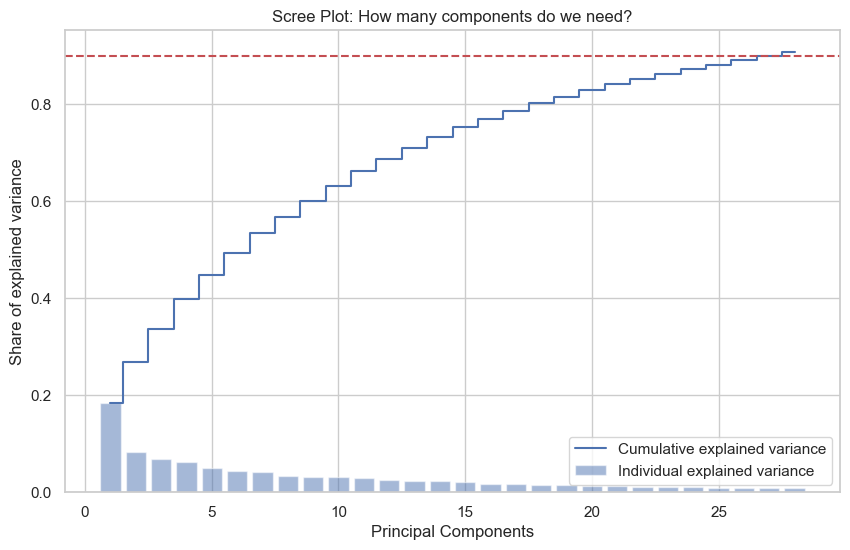

In [336]:
exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
    
plt.figure(figsize=(10, 6))
    
plt.bar(range(1, len(exp_var)+1), exp_var, alpha=0.5, align='center',
            label='Individual explained variance')
    
plt.step(range(1, len(cum_var)+1), cum_var, where='mid',
             label='Cumulative explained variance')
    
plt.ylabel('Share of explained variance')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
plt.title("Scree Plot: How many components do we need?")
plt.show()

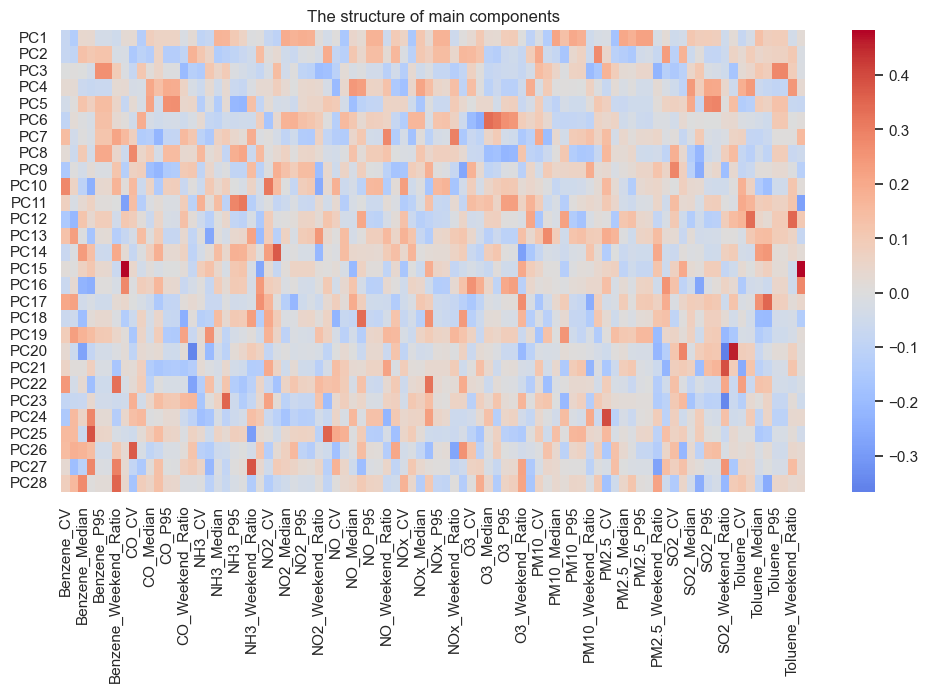

In [337]:
components_df = pd.DataFrame(
        pca.components_, 
        columns=station_profile_final.columns,
        index=[f'PC{i+1}' for i in range(pca.n_components_)]
    )
    
plt.figure(figsize=(12, 6))
sns.heatmap(components_df.head(28), cmap='coolwarm', center=0)
plt.title("The structure of main components")
plt.show()

In [338]:
print("\n--- Components structure ---")
for i in range(min(28, pca.n_components_)):
        pc_name = f'PC{i+1}'
        print(f"\n{pc_name} mainly depends on:")
        top_features = components_df.loc[pc_name].abs().sort_values(ascending=False).head(5)
        print(top_features)


--- Components structure ---

PC1 mainly depends on:
PM2.5_P95              0.220626
PM2.5_Range_P95_P05    0.218972
PM10_Median            0.211758
PM2.5_Median           0.205555
PM10_P95               0.199232
Name: PC1, dtype: float64

PC2 mainly depends on:
PM10_WinterSummer_Ratio     0.271913
PM2.5_WinterSummer_Ratio    0.231776
PM10_CV                     0.202661
NO2_WinterSummer_Ratio      0.191608
CO_WinterSummer_Ratio       0.174561
Name: PC2, dtype: float64

PC3 mainly depends on:
Toluene_Range_P95_P05    0.281283
Toluene_P95              0.280697
Benzene_Range_P95_P05    0.262113
Benzene_P95              0.261792
PM2.5_Weekend_Ratio      0.224072
Name: PC3, dtype: float64

PC4 mainly depends on:
Toluene_Weekend_Ratio     0.246363
NO_Median                 0.242056
SO2_Median                0.240852
Toluene_DayNight_Ratio    0.240004
NO_P05                    0.226003
Name: PC4, dtype: float64

PC5 mainly depends on:
SO2_Range_P95_P05    0.290697
SO2_P95              0.280

In [339]:
station_profile_final

,Benzene_CV,Benzene_DayNight_Ratio,Benzene_Median,Benzene_P05,Benzene_P95,Benzene_Range_P95_P05,Benzene_Weekend_Ratio,Benzene_WinterSummer_Ratio,CO_CV,CO_DayNight_Ratio,...,SO2_Weekend_Ratio,SO2_WinterSummer_Ratio,Toluene_CV,Toluene_DayNight_Ratio,Toluene_Median,Toluene_P05,Toluene_P95,Toluene_Range_P95_P05,Toluene_Weekend_Ratio,Toluene_WinterSummer_Ratio
AP001,10.192371,1.337336,0.10,0.000,1.0000,1.0000,1.277378,0.333014,0.834377,1.018638,...,0.934027,1.300971,5.818948,0.841472,0.632667,0.000000,6.620000,6.620000,0.720513,0.697054
AP005,0.843365,1.039525,3.35,0.000,10.2580,10.2580,0.960245,1.245364,0.952370,1.203462,...,1.016796,0.826531,0.935419,0.936660,6.900000,0.000000,22.200000,22.200000,0.986045,0.931992
AS001,5.479457,1.387082,0.23,0.000,6.5495,6.5495,0.583218,0.315622,0.852865,0.694436,...,1.021056,1.080350,0.000000,1.000000,2.960000,2.960000,2.960000,0.000000,1.000000,1.000000
BR005,1.305964,1.070895,1.54,0.000,10.6560,10.6560,1.073303,4.691126,0.962802,1.104748,...,0.999416,4.070716,1.302783,1.112997,3.370000,0.000000,9.803333,9.803333,0.964419,0.863160
BR006,1.227756,0.913135,1.31,0.000,7.6560,7.6560,1.068731,2.440758,0.445820,0.957317,...,0.963045,1.361561,3.730559,1.134933,0.220000,0.000000,1.130000,1.130000,0.944038,1.855972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WB009,1.736667,0.652256,4.55,0.720,41.1700,40.4500,0.888980,1.567782,0.867852,0.765521,...,0.994001,2.642833,1.368204,0.724354,12.450000,0.180000,54.902500,54.722500,1.059124,3.263763
WB010,0.818439,0.796150,52.88,1.115,148.0100,146.8950,1.075745,1.760191,0.916642,0.741298,...,0.995071,2.113585,0.983503,0.769692,53.482857,4.320553,197.425000,193.104447,1.010347,1.915700
WB011,1.482201,0.695762,3.85,0.340,24.2560,23.9160,0.918727,2.409862,1.119980,0.817232,...,0.929468,1.809159,1.375970,0.814854,7.340000,0.663158,41.729000,41.065842,0.894780,1.238683
WB012,1.558309,0.715902,4.00,0.770,33.7275,32.9575,0.876581,5.213138,1.247608,0.907857,...,1.000646,3.966425,1.280625,0.681590,6.385000,1.200000,39.210000,38.010000,0.973267,3.814536


In [340]:
X_pca.shape

(110, 28)

To define number of clusters mathematically and find out for what number of clusters the distance between data points within one cluster is smaller (Elbow method) and how well datapoints fit defined clusters (Silhouette method).

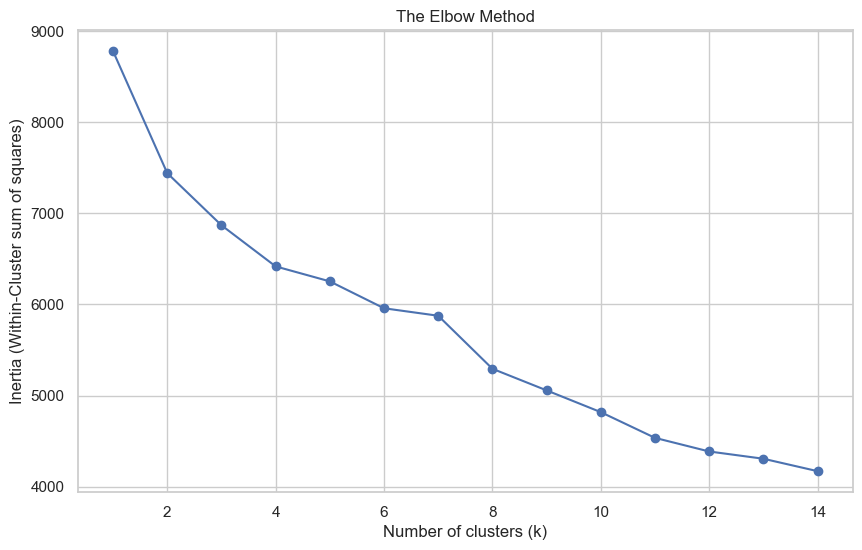

In [341]:
inertia = []
K_range = range(1, 15)  # Test k from 1 to 15

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)  # Use your PCA data (28 components)
    inertia.append(kmeans.inertia_)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster sum of squares)')
plt.show()

The Elbow method shows that in general, the main metric whithin cluster sum of squares is gradually decreasing with growing number of clusters. The smaller the within-cluster sum of squares the tighter is the cluster.

The greatest decrease in the metrics is for the 8 clusters. However, we also need to take into accpunt the Shilouette method.

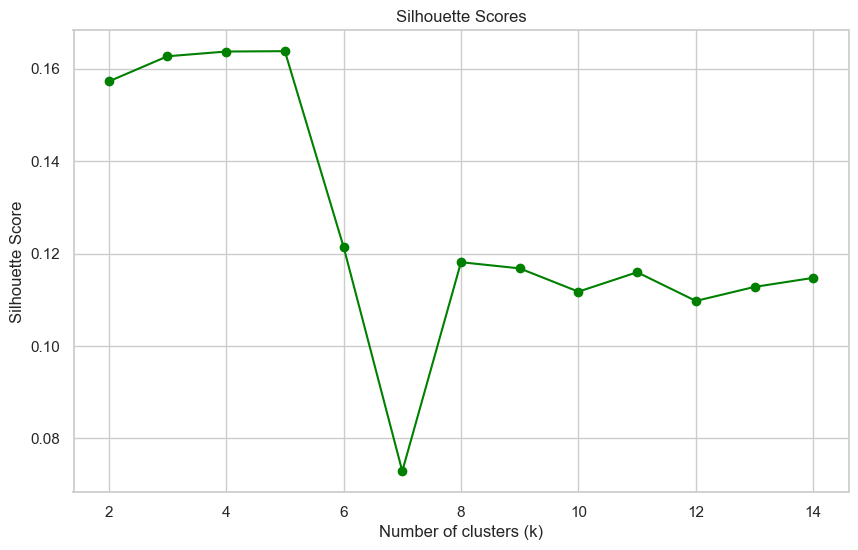

In [342]:
silhouette_scores = []
K_range_sil = range(2, 15) # Silhouette cannot be calculated for k=1

for k in K_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    
    # Calculate average score for this k
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(K_range_sil, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

For Silhouette method, where the Silhouette score shows how well datapoints suit the defined number of clusters. The higher the silhouette score (the closer to 1) the better, meaning that the datapoints are closer to the datapoints from its own cluster and far away from the datapoints of the neighbouring cluster. The values close to 0 mean that the datapoints are closer to the neighbourig cluster rather than to the datapoints of its own cluster.

In our case there is the local minimum of the silhouette score fir 7 clusters, meanwhile maximum score is achieved for the 5 clusters. Considering this it will be better to choose 5 clusters.

In [343]:
kmeans = KMeans(n_clusters=5, random_state=42)

labels = kmeans.fit_predict(X_pca) 

df_analysis = station_profile_final.copy()
df_analysis['Cluster'] = labels

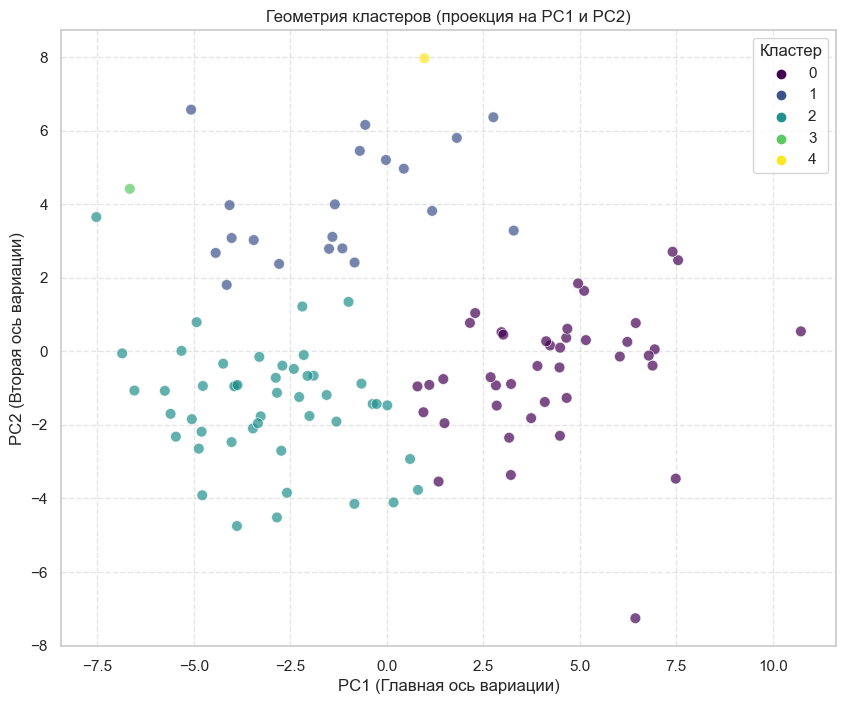

In [344]:
def plot_pca_clusters(X_pca, labels):
    plt.figure(figsize=(10, 8))
    
    pca_viz = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
    pca_viz['Cluster'] = labels
    
    # Рисуем
    sns.scatterplot(
        data=pca_viz, 
        x='PC1', 
        y='PC2', 
        hue='Cluster', 
        palette='viridis', 
        s=60,
        alpha=0.7
    )
    
    plt.title('Геометрия кластеров (проекция на PC1 и PC2)')
    plt.xlabel('PC1 (Главная ось вариации)')
    plt.ylabel('PC2 (Вторая ось вариации)')
    plt.legend(title='Кластер')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# ЗАПУСК
plot_pca_clusters(X_pca, labels)

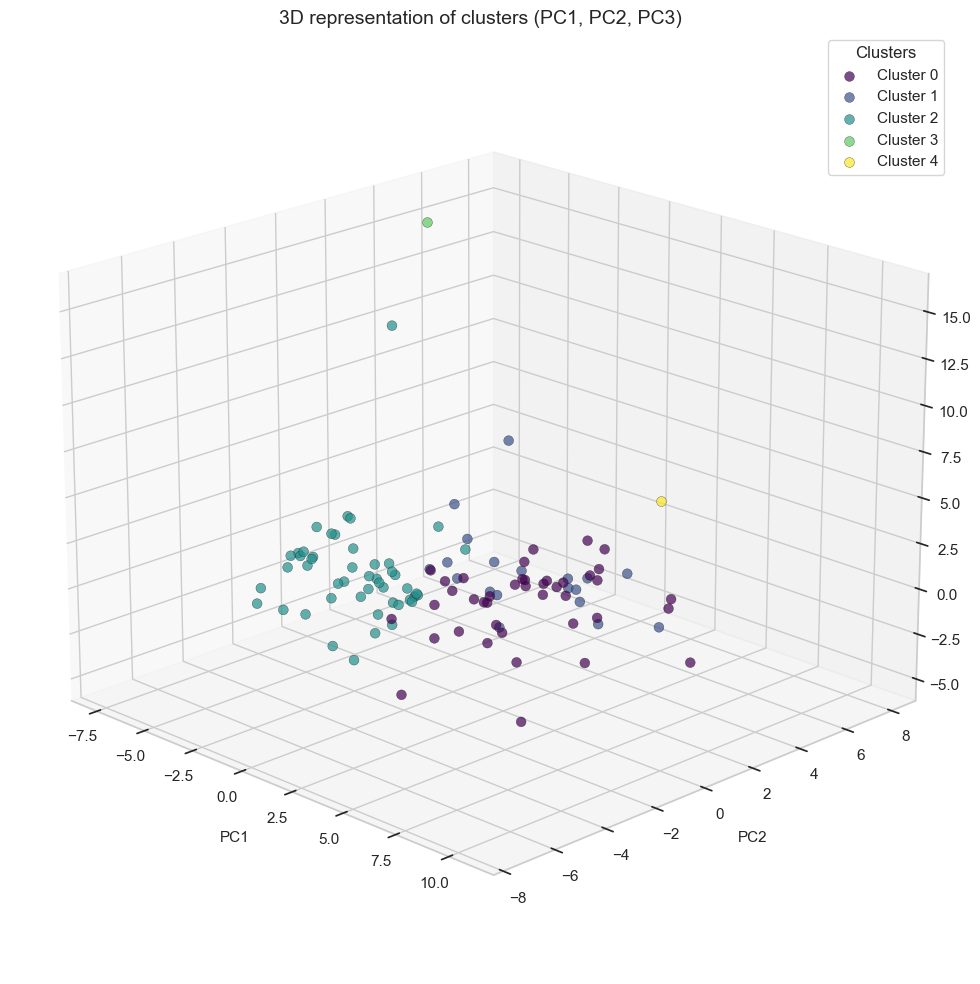

In [359]:
def plot_pca_clusters_3d(X_pca, labels):
    """
    Строит 3D scatter plot by first three PCA.
    """
    if X_pca.shape[1] < 3:
        print("Error: For this 3D graph minimum 3 PC needed in X_pca.")
        return

    pca_viz = pd.DataFrame(X_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
    pca_viz['Cluster'] = labels

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
    
    for i, cluster_label in enumerate(unique_labels):
        cluster_data = pca_viz[pca_viz['Cluster'] == cluster_label]
        
        ax.scatter(
            xs=cluster_data['PC1'], 
            ys=cluster_data['PC2'], 
            zs=cluster_data['PC3'], 
            c=[colors[i]],           
            label=f'Cluster {cluster_label}',
            s=50,                    # dots size
            alpha=0.7,               # transparency
            edgecolor='k', linewidth=0.3 # thin outline for dots
        )

    ax.set_title('3D representation of clusters (PC1, PC2, PC3)', fontsize=14)
    ax.set_xlabel('PC1', fontsize=11, labelpad=10)
    ax.set_ylabel('PC2', fontsize=11, labelpad=10)
    ax.set_zlabel('PC3', fontsize=11, labelpad=10)

    ax.legend(title="Clusters", loc='best')
    
    ax.view_init(elev=20, azim=-45) 

    plt.tight_layout()
    plt.show()

plot_pca_clusters_3d(X_pca, labels)

In [360]:
# statistics for each cluster
clusters_stats = pd.DataFrame(df_analysis.groupby('Cluster').median()).reset_index()
clusters_stats

TypeError: agg function failed [how->median,dtype->object]

In [347]:
station_meta = station_hour[['StationId', 'StationName', 'City', 'State']]
station_grouped = station_meta.drop_duplicates(subset=['StationId']).reset_index(drop=True)

station_grouped.head()

,StationId,StationName,City,State
0,AP001,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh
1,AP005,"GVM Corporation, Visakhapatnam - APPCB",Visakhapatnam,Andhra Pradesh
2,AS001,"Railway Colony, Guwahati - APCB",Guwahati,Assam
3,BR005,"DRM Office Danapur, Patna - BSPCB",Patna,Bihar
4,BR006,"Govt. High School Shikarpur, Patna - BSPCB",Patna,Bihar


In [349]:
df_analysis = df_analysis.merge(station_grouped, 
                  left_index=True,
                 right_on = 'StationId')

In [351]:
city_cluster_counts = pd.crosstab(
    index=df_analysis['City'], 
    columns=df_analysis['Cluster'],
    margins=True,
    margins_name="Total"
)

city_cluster_counts = city_cluster_counts.sort_values('Total', ascending=False)

city_cluster_counts

Cluster,0,1,2,3,4,Total
City,,,,,,
Total,41,20,47,1,1,110
Delhi,38,0,0,0,0,38
Bengaluru,0,0,10,0,0,10
Mumbai,0,7,3,0,0,10
Kolkata,0,6,0,0,1,7
Patna,1,4,1,0,0,6
Hyderabad,0,0,6,0,0,6
Lucknow,0,0,5,0,0,5
Chennai,0,0,4,0,0,4


In [352]:
city_cluster_shares = pd.crosstab(
    index=df_analysis['City'], 
    columns=df_analysis['Cluster'],
    normalize='index'
)

city_cluster_percentages = (city_cluster_shares * 100).round(1)
city_cluster_percentages

city_cluster_percentages.merge(city_cluster_counts, on='City')

Cluster,0,1,2,3,4
City,,,,,
Ahmedabad,100.0,0.0,0.0,0.0,0.0
Aizawl,0.0,0.0,100.0,0.0,0.0
Amaravati,0.0,0.0,100.0,0.0,0.0
Amritsar,0.0,0.0,100.0,0.0,0.0
Bengaluru,0.0,0.0,100.0,0.0,0.0
Bhopal,0.0,0.0,100.0,0.0,0.0
Brajrajnagar,0.0,0.0,100.0,0.0,0.0
Chandigarh,0.0,0.0,100.0,0.0,0.0
Chennai,0.0,0.0,100.0,0.0,0.0


In [354]:
# distribution of clusters among the variables
city_cluster_total = city_cluster_counts.merge(city_cluster_percentages, on='City')
city_cluster_total = city_cluster_total.rename(columns = {
    '0_x':'0_cnt', 
    '1_x':'1_cnt', 
    '2_x':'2_cnt', 
    '3_x':'3_cnt',
    '4_x':'4_cnt', 
    'Total':'Total_cnt', 
    '0_y':'0_share', 
    '1_y':'1_share', 
    '2_y':'2_share',
    '3_y':'3_share', 
    '4_y':'4_share'
})
city_cluster_total = city_cluster_total[['0_cnt', '0_share', 
                                         '1_cnt', '1_share', 
                                         '2_cnt', '2_share', 
                                         '3_cnt', '3_share', 
                                         '4_cnt', '4_share',
                                         'Total_cnt']]
city_cluster_total

Cluster,0_cnt,0_share,1_cnt,1_share,2_cnt,2_share,3_cnt,3_share,4_cnt,4_share,Total_cnt
City,,,,,,,,,,,
Delhi,38,100.0,0,0.0,0,0.0,0,0.0,0,0.0,38
Bengaluru,0,0.0,0,0.0,10,100.0,0,0.0,0,0.0,10
Mumbai,0,0.0,7,70.0,3,30.0,0,0.0,0,0.0,10
Kolkata,0,0.0,6,85.7,0,0.0,0,0.0,1,14.3,7
Patna,1,16.7,4,66.7,1,16.7,0,0.0,0,0.0,6
Hyderabad,0,0.0,0,0.0,6,100.0,0,0.0,0,0.0,6
Lucknow,0,0.0,0,0.0,5,100.0,0,0.0,0,0.0,5
Chennai,0,0.0,0,0.0,4,100.0,0,0.0,0,0.0,4
Gurugram,1,25.0,0,0.0,3,75.0,0,0.0,0,0.0,4


### Surrogate Modeling: clusters description

After we have recieved stations distributed to clusters and placed the clustering from the station level to the level of cities, It is important to understand get the description for each cluster. Since kmeas algorithm is based on eucledian distance and it is complext to understand how this model works and which features it has used. Moreover, it is time consuming to analyze all 88 statisitcs that we got for each cluster.

Therefore, it is rational to use surrogate modeling or in other words aplly to dataset with clusters Decision Tree Classifier to make it explain rules for clusters definition. Decision Tree Algorithm defines most important features and creates if-then-else tree, based on which each of the clusters can be explained.

In [364]:
# defining relevant 88 features
features = df_analysis.columns.drop(['Cluster', 'StationId', 'StationName', 'City', 'State'])
features.shape

(88,)

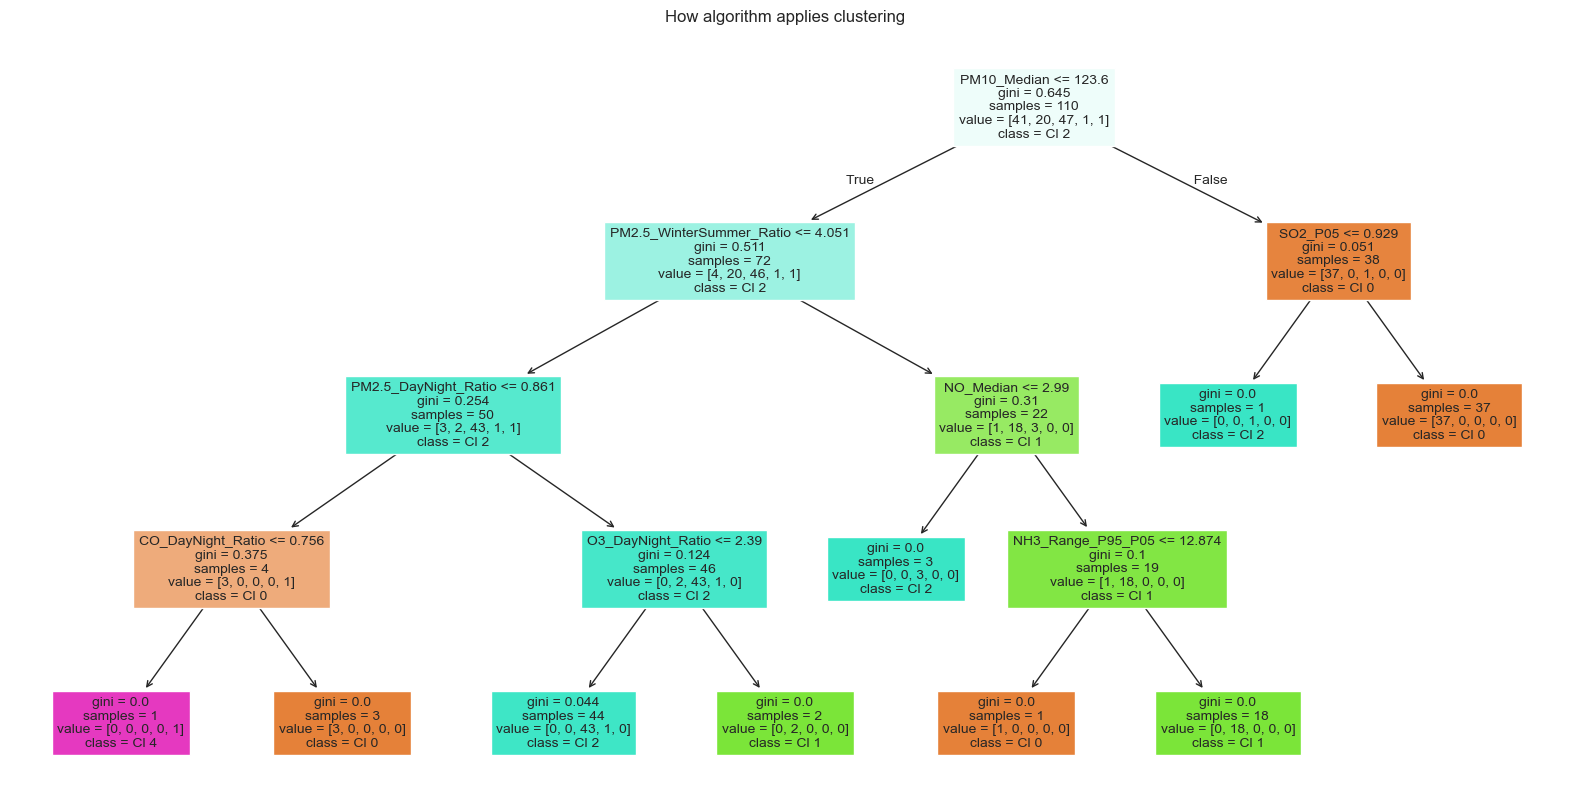

In [366]:
# Training Decision Tree classifier to reveal the rules for defining clusters
X_explain = df_analysis[features]
y_explain = df_analysis['Cluster']

# Constraining the tree depth by 4 to make it explainable
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_explain, y_explain)

# Vizualizing the model
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X_explain.columns, class_names=['Cl 0', 'Cl 1', 'Cl 2', 'Cl 3', 'Cl 4'], filled=True, fontsize=10)
plt.title("How algorithm applies clustering")
plt.show()